The following Jupiter Notebook seeks to compile data from 3 different Excel documents to ultimately relate Twitter engagements for a player with the player's salary and stats to see what player specfific parameters are best at determining social media popularity.

The import statements:

In [281]:
import pandas as pd 
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import math

Load the data frames:

In [282]:
#twitter data
twitter = pd.read_csv(r'C:\Users\mattc\OneDrive\Desktop\MyProjects\social-power-nba\nba_2017_twitter_players.csv')
#salary data
salary = pd.read_csv(r'C:\Users\mattc\OneDrive\Desktop\MyProjects\social-power-nba\nba_2017_salary.csv')
#player stats
stats = pd.read_csv(r'C:\Users\mattc\OneDrive\Desktop\MyProjects\social-power-nba\nba_2017_players_stats_combined.csv')
#show the head of each dataframe
print('Twitter')
print('size of frame:', twitter.shape)
print(twitter.head())
print('Salary')
print('size of frame:', salary.shape)
print(salary.head())
print('Stats')
print('size of frame:', stats.shape)
print(stats.head())

Twitter
size of frame: (329, 3)
              PLAYER  TWITTER_FAVORITE_COUNT  TWITTER_RETWEET_COUNT
0  Russell Westbrook                  2130.5                  559.0
1       James Harden                   969.0                  321.5
2      Isaiah Thomas                   467.5                  155.5
3      Anthony Davis                   368.0                  104.0
4      DeMar DeRozan                     0.0                  186.0
Salary
size of frame: (449, 4)
              NAME POSITION                 TEAM      SALARY
0     LeBron James       SF  Cleveland Cavaliers  30963450.0
1      Mike Conley       PG    Memphis Grizzlies  26540100.0
2       Al Horford        C       Boston Celtics  26540100.0
3    Dirk Nowitzki       PF     Dallas Mavericks  25000000.0
4  Carmelo Anthony       SF      New York Knicks  24559380.0
Stats
size of frame: (446, 38)
   Unnamed: 0  Rk             PLAYER POSITION  AGE    MP    FG   FGA    FG%  \
0           0   1  Russell Westbrook       PG   28  3

Joining Data:
The goal is to join on player

In [283]:
#the intermediate, twitter and salary. Twitter first bc size is limited by twitter
salary.drop(['POSITION', 'TEAM'], axis = 1, inplace = True)
inter = twitter.set_index('PLAYER').join(salary.set_index('NAME'))
#join inter with stats
stats.drop(stats.columns[stats.columns.str.contains('Unnamed', case = False)], axis = 1, inplace = True)
df = inter.join(stats.set_index('PLAYER'))
print('The shape of the df')
print(df.shape)
print('The head of the df')
print(df.head())
print('the list of features in the dataframe')
print(df.columns)

The shape of the df
(330, 39)
The head of the df
                 TWITTER_FAVORITE_COUNT  TWITTER_RETWEET_COUNT      SALARY  \
Aaron Brooks                        1.0                    3.0   2700000.0   
Aaron Gordon                       42.5                   16.0   4351320.0   
Adreian Payne                       0.0                   13.0   2022240.0   
Al Horford                        136.0                   71.0  26540100.0   
Al-Farouq Aminu                    33.0                    9.0   7680965.0   

                    Rk POSITION   AGE    MP   FG   FGA    FG%  ...  TEAM  \
Aaron Brooks     328.0       PG  32.0  13.8  1.9   4.6  0.403  ...   IND   
Aaron Gordon     101.0       SF  21.0  28.7  4.9  10.8  0.454  ...   ORL   
Adreian Payne    381.0       PF  25.0   7.5  1.3   3.0  0.426  ...   MIN   
Al Horford        78.0        C  30.0  32.3  5.6  11.8  0.473  ...   BOS   
Al-Farouq Aminu  185.0       SF  26.0  29.1  3.0   7.6  0.393  ...   POR   

                   GP   M

Later adhoc analysis found repeated rows. Eliminate.

In [284]:
#a list names that are duplicated
dup = []
for i in df.index:
    rows = list(df.index)
    rows.remove(i)
    for j in rows:
        if i == j:
            dup.append(i)
print(dup)

['Bobby Portis', 'Bobby Portis']


Bobby Portis is the one repeat, one of his rows should be droped. Only one so as to keep the other. Following code finds the first Bobby Portis row and drops it.

In [285]:
#convert index to numeric
df.reset_index(inplace = True)
#iterate over df and remove first instance
for i in range(0, len(df.index)):
    if df.loc[i, 'index'] == 'Bobby Portis':
        df.drop(i, axis = 0, inplace = True)
        break
#convert index back to player name
df.index = df['index']
df.drop('index', axis = 1, inplace = True)
#verify that a singular entry for Bobby Portis now exists
print(df.loc['Bobby Portis'])

TWITTER_FAVORITE_COUNT             37
TWITTER_RETWEET_COUNT              73
SALARY                    1.51632e+06
Rk                                244
POSITION                           PF
AGE                                21
MP                               15.6
FG                                2.9
FGA                               5.9
FG%                             0.488
3P                                0.5
3PA                               1.5
3P%                             0.333
2P                                2.4
2PA                               4.4
2P%                             0.541
eFG%                            0.531
FT                                0.6
FTA                               0.9
FT%                             0.661
ORB                               1.2
DRB                               3.5
TRB                               4.6
AST                               0.5
STL                               0.3
BLK                               0.2
TOV         

Should I use Twitter favorites or retweets as the dependent variable?
Let's look at distribution of each

Twitter Favorites Distribution
mean 183.409509202454
standard deviation 877.4341624751836
Twitter Retweets Distribution
mean 72.70245398773007
standard deviation 287.5946326557934


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BB944484A8>]],
      dtype=object)

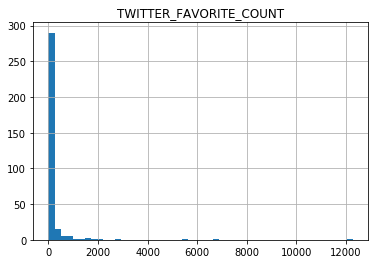

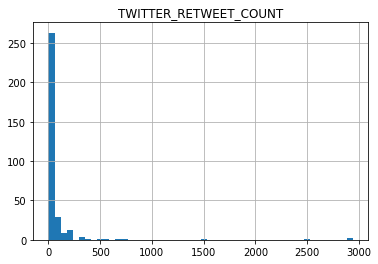

In [286]:
#twitter favorites
print('Twitter Favorites Distribution')
print('mean', df['TWITTER_FAVORITE_COUNT'].mean())
print('standard deviation', df['TWITTER_FAVORITE_COUNT'].std())
df.hist(column='TWITTER_FAVORITE_COUNT', bins = 50)
#twitter retweets
print('Twitter Retweets Distribution')
print('mean', df['TWITTER_RETWEET_COUNT'].mean())
print('standard deviation', df['TWITTER_RETWEET_COUNT'].std())
df.hist(column='TWITTER_RETWEET_COUNT', bins = 50)

On average, players get more favorites than retweets, but the higher favorites average is pulled up by strong outliers. Both are heavily right skewed with many 0 values. It could be effective to see which can be attributed to more players, like did more players register retweets or favorites? This way we can capture more of an effect ideally.

In [287]:
num_player_retweets = 0 
num_player_favs = 0
#iterate over index and count players that register each twitter metric
for i in df.index:
    if df.loc[i, 'TWITTER_FAVORITE_COUNT'] !=0:
        num_player_favs = num_player_favs +1
    if df.loc[i, 'TWITTER_RETWEET_COUNT'] !=0:
        num_player_retweets = num_player_retweets +1
print('The number of players with favs:', num_player_favs)
print('The number of players with retweets:', num_player_retweets)      

The number of players with favs: 269
The number of players with retweets: 323


It seems that more players register retweets. Ultimately, the higher average number of favs being pulled up by high outliers is favored by this notion.

Feature Selection:

First, build a model with each term in linear form. This will allow for residuals plotted against each feature to show signs of heteroskedsatictiy, distribution for each feature, and potential configurations of appropriate functional forms. Using the residuals from a model containing all features will allow the potential for the zero conditional mean assumption to be biased to be much lower. This way, systematic patterns in the residuals are more likely to be attribuatable to misspecification of functional form rather than by systematic bias in the model from violation of zero conditional mean.

First, features need to be prepared for the basic linear model. Some of these features are catagorical and thus need to be dealt with. I need to see which these are

In [288]:
#print data types of each feature
print(df.dtypes)

TWITTER_FAVORITE_COUNT    float64
TWITTER_RETWEET_COUNT     float64
SALARY                    float64
Rk                        float64
POSITION                   object
AGE                       float64
MP                        float64
FG                        float64
FGA                       float64
FG%                       float64
3P                        float64
3PA                       float64
3P%                       float64
2P                        float64
2PA                       float64
2P%                       float64
eFG%                      float64
FT                        float64
FTA                       float64
FT%                       float64
ORB                       float64
DRB                       float64
TRB                       float64
AST                       float64
STL                       float64
BLK                       float64
TOV                       float64
PF                        float64
POINTS                    float64
TEAM          

Team and position need to be converted to categorical variables.

In [289]:
df = pd.get_dummies(df, drop_first = False)
print(df.head())

                 TWITTER_FAVORITE_COUNT  TWITTER_RETWEET_COUNT      SALARY  \
index                                                                        
Aaron Brooks                        1.0                    3.0   2700000.0   
Aaron Gordon                       42.5                   16.0   4351320.0   
Adreian Payne                       0.0                   13.0   2022240.0   
Al Horford                        136.0                   71.0  26540100.0   
Al-Farouq Aminu                    33.0                    9.0   7680965.0   

                    Rk   AGE    MP   FG   FGA    FG%   3P  ...  TEAM_ORL/TOR  \
index                                                      ...                 
Aaron Brooks     328.0  32.0  13.8  1.9   4.6  0.403  0.7  ...             0   
Aaron Gordon     101.0  21.0  28.7  4.9  10.8  0.454  1.0  ...             0   
Adreian Payne    381.0  25.0   7.5  1.3   3.0  0.426  0.2  ...             0   
Al Horford        78.0  30.0  32.3  5.6  11.8  0.473 

We now have categories. We can build the model. First, we should verify that no features contain inf or nan values

In [290]:
#iterate over and place in right list if has nan or inf val
for i in df.columns:
    print('The number of nulls in', i , df[i].isnull().sum())

The number of nulls in TWITTER_FAVORITE_COUNT 3
The number of nulls in TWITTER_RETWEET_COUNT 3
The number of nulls in SALARY 74
The number of nulls in Rk 26
The number of nulls in AGE 26
The number of nulls in MP 26
The number of nulls in FG 26
The number of nulls in FGA 26
The number of nulls in FG% 26
The number of nulls in 3P 26
The number of nulls in 3PA 26
The number of nulls in 3P% 37
The number of nulls in 2P 26
The number of nulls in 2PA 26
The number of nulls in 2P% 26
The number of nulls in eFG% 26
The number of nulls in FT 26
The number of nulls in FTA 26
The number of nulls in FT% 30
The number of nulls in ORB 26
The number of nulls in DRB 26
The number of nulls in TRB 26
The number of nulls in AST 26
The number of nulls in STL 26
The number of nulls in BLK 26
The number of nulls in TOV 26
The number of nulls in PF 26
The number of nulls in POINTS 26
The number of nulls in GP 26
The number of nulls in MPG 26
The number of nulls in ORPM 26
The number of nulls in DRPM 26
The 

There are many nulls in salary to the point where it may not be helpful at all to impute the values. Otherwise, the other na's all basically overlap through all the statistical categories used for prediction, and there are 3 missings for both twitter engagements which are the depdent variable. So, it makes sense to delete all na's because this is so wide spread.

In [291]:
df.dropna(inplace = True)

There is also this problem of players that have two different teams that they played for for the season. The following code returns the number of entries that this is true for

In [292]:
#count number of players who played for multiple teams
#get list of columns that have slash
slash = []
for i in list(df.columns):
    if '/' in i:
        slash.append(i)
#count the number of 1's in each
count = 0
for i in slash:
    count = count + df[i].sum()
print(count)

22


There are 22 players that switched teams included in the data set. Holding the extra features that in most or likely all cases only have one entry seems nonsensical. There are so many variables that go into this other than just the fact that there was an exchange between teams. So, all will be removed.

In [293]:
df.drop(slash, axis = 1, inplace = True)

Because there are many features, I do not want to have to look through every graph to check for homoskedasticity and no patterns. The following functions deal with this

In [294]:
#a function that returns if the correlation between residuals and a feature exceed a threshold
def check_corr(res, x, thresh):
    cor = np.corrcoef(x, stan_resid)[0][1]
    if cor > thresh:
        print(x.name, 'is correleted with the residuals by more than', thresh)

#a function that returns if the difference between standard deviations divided by the larger of the two is greater than some threshold proportion
def check_homo(res, x, thresh):
    mid = x.median()
    bucket_1 = []
    bucket_2 = []
    for i in range(0, len(res)):
        if x[i] <= mid:
            bucket_1.append(res[i])
        else:
            bucket_2.append(res[i])
    bucket_1 = np.array(bucket_1)
    bucket_2 = np.array(bucket_2)
    std_1 = bucket_1.std()
    std_2 = bucket_2.std()
    large = 0
    if std_1 > std_2:
        large = std_1
    else:
        large = std_2
    stan_diff = abs(std_1 - std_2)/large
    if stan_diff > thresh:
        print('The difference in standard deviations between', x.name, 'and the residuals is larger than the threshold of', thresh)
    

Build linear model and check zero conditional mean and homoskedasticity assumptions using previous set of functions:

In [295]:
#the dependent variable is retweets
y = df['TWITTER_RETWEET_COUNT']
#the indepedent variables are all others
X = df.drop(['TWITTER_RETWEET_COUNT','TWITTER_FAVORITE_COUNT'], axis = 1)
#the model
model = sm.OLS(y,sm.add_constant(X, has_constant='add')).fit()
#plot the model residuals against each covariate
resid = model.resid
resid_dev = np.std(resid)
stan_resid = np.true_divide(resid, resid_dev)
#iterate over the features, place features the correlate highly with errors in list, graph features vs x to check homoskedasticity
for i in df.drop(['TWITTER_RETWEET_COUNT','TWITTER_FAVORITE_COUNT'], axis = 1).columns:
    #check corelation
    cor_thresh = 0.1
    check_corr(stan_resid, df[i], cor_thresh)
    #check homoskedasticity
    homo_thresh = 0.5
    check_homo(stan_resid, df[i], homo_thresh)

The difference in standard deviations between Rk and the residuals is larger than the threshold of 0.5
The difference in standard deviations between MP and the residuals is larger than the threshold of 0.5
The difference in standard deviations between FG and the residuals is larger than the threshold of 0.5
The difference in standard deviations between FGA and the residuals is larger than the threshold of 0.5
The difference in standard deviations between FG% and the residuals is larger than the threshold of 0.5
The difference in standard deviations between 2P and the residuals is larger than the threshold of 0.5
The difference in standard deviations between 2PA and the residuals is larger than the threshold of 0.5
The difference in standard deviations between FT and the residuals is larger than the threshold of 0.5
The difference in standard deviations between FTA and the residuals is larger than the threshold of 0.5
The difference in standard deviations between FT% and the residuals i

In many cases as depicted above, the difference in standard deviations between the two halves of the data exceeds 50% of the value of the larger of the two standard deviations. This suggests that homoskedasticity may in fact be a problem and that reservation should be taken in the statistical inference process.

The other two assumptions that need to be checked are:
1.) normality of the error
2.) mulicolinearity

CHECK NORMALITY OF ERRORS:

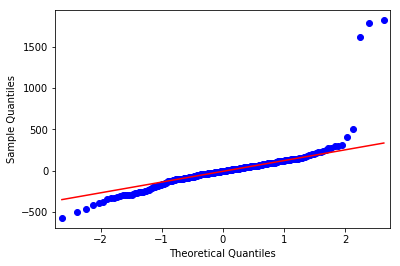

In [296]:
#graph the qq plot
sm.qqplot(resid, line = 'q')
plt.show()

It is seemingly perfectly linear in the middle, but skewed off at the ends. Let's look at a histogram of the distribution:

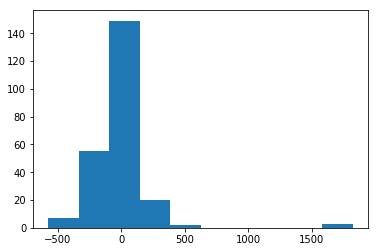

In [297]:
#a histogram of the residuals
plt.hist(resid)
plt.show()

There is very large skew due to what looks like 3 large positive residuals based on the QQ plot. Let's find which players are causing the large residuals

In [298]:
#sort the residuals
resid.sort_values(inplace = True)
#print the top 3
print('The max residual is', list(resid)[-1])
print('The player with this residal is', resid.index[-1])
print('The second highest residual is', list(resid)[-2])
print('The player with this residal is', resid.index[-2])
print('The third highest residual is', list(resid)[-3])
print('The player with this residal is', resid.index[-3])

The max residual is 1822.6989795386394
The player with this residal is Derrick Rose
The second highest residual is 1784.063632511076
The player with this residal is Stephen Curry
The third highest residual is 1619.512114521478
The player with this residal is Joel Embiid


Derrick Rose had decent statistics this year, but he also had one of the highest retweet levels that seems to be disproportionate to his statistics. This makes sense because he developed a massive following due to his MVP season and injury drama. He may have been an MVP, but in this case he biases the model so he will be eliminated. Steph Curry is Steph Curry and Joel Embiid is Joel Embiid. They will be kept because they don't embody this unique case that Derrick Rose does.

In [299]:
#drop derrick rose to redefine the data frame
df.drop(player, axis = 0, inplace = True)
#redefine y and X
y = df['TWITTER_RETWEET_COUNT']
X = df.drop(['TWITTER_RETWEET_COUNT','TWITTER_FAVORITE_COUNT'], axis = 1)

The last assumption that needs to be tested is multicolinearity:

In [300]:
#regress each regressor against all others and print out which feature VIF>10
for i in df.columns:
    x = df[i]
    regressors = list(df.columns)
    regressors.remove(i)
    Z = df[regressors]
    model_x = sm.OLS(x,sm.add_constant(Z, has_constant='add')).fit()
    vif = 1/(1-model.rsquared)
    if vif >= 9:
        print(i, 'has VIF greater than 9')

C:\Users\mattc\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Surprisingly, no variables had a VIF that exceeds 9, implying that multicolinearity is not a huge concern in this instance. We can now build the model after making the adjustments and check for statistical signifigance

In [301]:
#the model
model = sm.OLS(y,sm.add_constant(X, has_constant='add')).fit()
#the alpha level
alpha = 0.05
#the pvalues
pvals = model.pvalues
#the coefficents
coef = model.params
#iterate over p values
for i in range(0, len(pvals)):
    if pvals[i]<=alpha:
        print(pvals.index[i] , 'is signifigant. It has a p-value of', pvals[i], 'The coefficent is', coef[i])

AST is signifigant. It has a p-value of 0.047301186058866435 The coefficent is -81.6236280642233
BLK is signifigant. It has a p-value of 0.010639553296551035 The coefficent is 207.2233948723005
TOV is signifigant. It has a p-value of 0.0008767991940151523 The coefficent is 277.07240085526934
TEAM_CLE is signifigant. It has a p-value of 0.013149509606196815 The coefficent is 382.94021121906565
TEAM_DAL is signifigant. It has a p-value of 0.02052656217397745 The coefficent is 402.4367849144121
TEAM_PHI is signifigant. It has a p-value of 0.013500665210055314 The coefficent is 358.69407236330994


This analysis suggests that Blocks and Turnover ratio both postively predict retweets and are statistically signifigant at the 5% level. Blocks make sense, but turnover ratio initially seems surprising. This may be because if a player has a large turnover ratio, they likely have the ball in their hands a lot and are a bigger part of the team, which may be the cause of increased fan attention and more retweets.

Interesting, assists corelate negetively with Twitter engagement. Perhaps players that accumulate more assists tend to have lower scoring averages or be less selfish players/people in general, which could be conducive to them demanding less social media precense.

Three teams had a signifigant effect at the 5% level. These include Cleveland, Dallas, and Philledelphia. Clevland makes sense because at this point they had 2 of the game's top players, a third all star, and the out spoken Jr. Smith. There was much discussion regarding the "trust the process" fad in Philly which could explain its signifigance, as well as having one of the game's biggest stars in Embid. Dallas, on the other hand, is an anomoly based on my NBA knowledge.

Remember, homoskedasticity may be violated and there is some deviation from normality, so these tests for signifigance may not be accurate.